In [1]:
# --- DEPENDENCY IMPORTS ---
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle

from datetime import datetime
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# --- DEVICE SETUP ---
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(device)


cuda


In [3]:
# --- EXPERIMENT IDENTIFIERS AND METRIC STORAGE ---

RUN_ID = "logos_v01_char_4layers"
LOG_FILE = "training_progress.log"

# **NEW**: Global list to store metrics in memory (for faster plotting)
METRICS_HISTORY = []

In [4]:
# --- DATA LOADING AND CHARACTER-LEVEL TOKENIZATION ---

# Adjust this path for your system
data_path = Path("data") / "philosophers.txt"

with data_path.open("r", encoding="utf-8") as f:
    text = f.read()

print(f"Loaded corpus with {len(text):,} characters.")

# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

def encode(s):
    return [stoi[c] for c in s]

def decode(indices):
    return ''.join(itos[i] for i in indices)

# Encode entire corpus
data = torch.tensor(encode(text), dtype=torch.long)

data_len = len(data)
train_end = int(0.9 * data_len)

train_data = data[:train_end]
val_data = data[train_end:]

print(f"Train chars: {train_end:,}, Val chars: {data_len - train_end:,}")

print("\nCorpus sample:")
print(text[:200])


Loaded corpus with 1,487,827 characters.
Vocab size: 86
Train chars: 1,339,044, Val chars: 148,783

Corpus sample:
﻿

=== PLATO ===

How you, O Athenians, have been affected by my accusers, I cannot tell;
but I know that they almost made me forget who I was—so persuasively
did they speak; and yet they have hardly 


In [5]:
block_size = 64
batch_size = 64

def get_random_chunk(split):
    """
    Return a random chunk of length (block_size + 1)
    from the given split.
    """

    if split == "train":
        start_idx = 0
        end_idx = train_end
    elif split == "val":
        start_idx = train_end
        end_idx = data_len
    else:
        raise ValueError("Unknown split")

    max_start = (end_idx - start_idx) - (block_size + 1)
    offset = torch.randint(0, max_start, (1,)).item()

    chunk_start = start_idx + offset
    chunk_end = chunk_start + block_size + 1

    return data[chunk_start:chunk_end]


def get_batch(split):
    xs = []
    ys = []
    for _ in range(batch_size):
        chunk = get_random_chunk(split)
        x = chunk[:-1]
        y = chunk[1:]
        xs.append(x)
        ys.append(y)

    x = torch.stack(xs).to(device)
    y = torch.stack(ys).to(device)
    return x, y


In [6]:
# MODEL VARIABLES
n_embd = 384                    # Embedding dimension — the size of each token’s vector.
n_head = 8                      # Number of attention heads.
n_layer = 8                     # Number of Transformer blocks/layers stacked.
dropout = 0.2                   # Randomly zeroes out 20% of connections during training to prevent overfitting.

# TRAINING CONTROL VARIABLES
max_iters = 2000                # How many training steps (batches) to run.
learning_rate = 3e-4            # Step size in optimization.
eval_iters = 100                # How many mini-batches to average when estimating training/validation loss.


In [7]:
class Head(nn.Module):
    """ one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        # computer attention scores ("affinities") with scaling
        weights = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B,T,T)

        # Apply causal masking
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        weights = self.dropout(weights)

        # perform the weighted aggregation
        out = weights @ v # (B ,T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel"""
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity"""
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4* n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x+y) # Add + Norm
        y = self.ffwd(x)
        x = self.ln2(x+y) # Add + Norm
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embeddings_table = nn.Embedding(vocabulary_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocabulary_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):

        B, T = index.shape

        tok_emb = self.token_embeddings_table(index)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            return logits, None
        
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
        return logits, loss
    

    def generate(self, index, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]

            # get the predictions
            logits, _ = self.forward(index_cond)
            
            # focus only on the last time step
            logits = logits[:, -1, :]  # (B,C)

            # Apply Temperature
            logits = logits / temperature

            # Apply Top-K sampling: 
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')

            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index


In [8]:
model = GPTLanguageModel(vocab_size).to(device)

In [9]:
def load_checkpoint(filepath):
    """Loads model and optimizer states from a checkpoint file."""
    global optimizer
    
    print(f"Attempting to load checkpoint from: {filepath}")
    
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model state dictionary loaded successfully.")

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Optimizer state dictionary loaded successfully.")

    # Return the step to resume from
    print(f"Run ID: {checkpoint.get('run_id', 'N/A')}. Resuming from step: {checkpoint['step']}")
    return checkpoint['step']


In [10]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(50):    # eval_iters
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out


In [11]:
def sample_and_log(step, train_loss, val_loss, 
                   prompt="Hello! Can you see me?",
                   max_new_tokens=200,
                   temperature=0.8,
                   top_k=50):

    model.eval()
    with torch.no_grad():
        torch.manual_seed(0)

        context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
        context = context.unsqueeze(0)

        out = model.generate(
            context,
            max_new_tokens=max_new_tokens,
            temperature=temperature, 
            top_k=top_k               
        )[0]

        text_out = decode(out.tolist())

    # Calculate metrics for logging
    train_ppl = math.exp(train_loss)
    val_ppl = math.exp(val_loss)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Create a dictionary of metrics to be returned and logged
    metrics_dict = {
        "run_id": RUN_ID,
        "step": step,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_ppl": train_ppl,
        "val_ppl": val_ppl,
    }
    
    # Create formatted log entry (for file persistence and console output)
    entry = (
        f"\n=== RUN {RUN_ID} STEP {step} @ {timestamp} ===\n"
        f"train loss: {train_loss:.3f} (ppl {train_ppl:.2f})\n"
        f"val   loss: {val_loss:.3f} (ppl {val_ppl:.2f})\n"
        f"prompt: {prompt}\n"
        f"sample:\n{text_out}\n"
        + "-"*50 + "\n"
    )

    # Write text sample/metrics to file for persistent history
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(entry)

    print(entry)
    model.train()
    
    return metrics_dict # Return the metrics for in-memory storage


In [12]:
# --- MAIN TRAINING AND CHECKPOINT LOOP ---

max_iters = 2000
eval_every = 500
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# --- Checkpoint Loading/Resumption Logic ---
start_step = 0

# To RESUME TRAINING, uncomment the two lines below and update the file path:
# CHECKPOINT_PATH = "checkpoint_logos_v01_char_4layers_step2000.pt" 
# start_step = load_checkpoint(CHECKPOINT_PATH)

# Optional: If resuming, you might want to load past metrics from the log file here.
# For simplicity in this demo, METRICS_HISTORY will only contain metrics from the current run forward.
# -------------------------------------------

for step in range(start_step, max_iters):

    # Evaluate + log + Save Checkpoint
    if step == start_step or step % eval_every == 0: 
        losses = estimate_loss()
        train_loss, val_loss = losses["train"], losses["val"]
        
        if step != start_step:
            print(f"step {step}: train {train_loss:.3f}, val {val_loss:.3f}")

        # Call logging function and CAPTURE the metrics dictionary
        metrics = sample_and_log(
            step=step,
            train_loss=train_loss,
            val_loss=val_loss,
            prompt="Hello! Can you see me?"
        )
        METRICS_HISTORY.append(metrics) # **NEW**: Store metrics in memory

        # Save checkpoint
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "step": step,
            "run_id": RUN_ID,
        }, f"checkpoint_{RUN_ID}_step{step}.pt")

    # Normal training step
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# --- FINAL EVALUATION AND SAVE (AFTER LOOP COMPLETION) ---

losses = estimate_loss()
final_train_loss, final_val_loss = losses["train"], losses["val"]

metrics = sample_and_log(
    step=max_iters, 
    train_loss=final_train_loss,
    val_loss=final_val_loss,
    prompt="Hello! Can you see me?"
)
METRICS_HISTORY.append(metrics) # **NEW**: Store final metrics

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "step": max_iters, 
    "run_id": RUN_ID,
}, f"checkpoint_{RUN_ID}_step{max_iters}.pt")

print("Training complete.")



=== RUN logos_v01_char_4layers STEP 0 @ 2025-12-08 21:33:01 ===
train loss: 4.515 (ppl 91.36)
val   loss: 4.513 (ppl 91.18)
prompt: Hello! Can you see me?
sample:
Hello! Can you see me?Mf5Ejæ’Pb-S8wx 4!9DK—wiPdjfouJ,L"p7WxVx7fBHtU 7i]HRaEx,﻿TIHJGXæ—eI﻿k5p7—;N*”qT=expR!YWBqEvt"]UM?:]﻿!-;IqlWr5e?RelxlgNr?f9'’eseeq]I0*AClX??qWw;)7;lJ’l'Ygp':f?;JlgU=BQYZ'U?JHuZ?5RaL“Fc﻿R7Zl?3
xJHæb2;rgI
--------------------------------------------------

step 500: train 1.509, val 1.482

=== RUN logos_v01_char_4layers STEP 500 @ 2025-12-08 21:33:33 ===
train loss: 1.509 (ppl 4.52)
val   loss: 1.482 (ppl 4.40)
prompt: Hello! Can you see me?
sample:
Hello! Can you see me? 
Opperation a possiblitions to the would be being a sultiment of a man conting and since that
who he collection, with these sences activil who all avourt to be of
of more of leasure is of greate them
--------------------------------------------------

step 1000: train 1.340, val 1.325

=== RUN logos_v01_char_4layers STEP 1000 @ 2025-12-08 

In [13]:
# --- CONVERT IN-MEMORY METRICS TO DATAFRAME ---

# Use the stored METRICS_HISTORY list directly to create the DataFrame
df = pd.DataFrame(METRICS_HISTORY).sort_values(["run_id","step"])
df


,run_id,step,train_loss,val_loss,train_ppl,val_ppl
0,logos_v01_char_4layers,0,4.514759,4.512815,91.355550,91.178094
1,logos_v01_char_4layers,500,1.508577,1.482424,4.520292,4.403606
2,logos_v01_char_4layers,1000,1.340286,1.324636,3.820136,3.760817
3,logos_v01_char_4layers,1500,1.289348,1.286732,3.630419,3.620935
4,logos_v01_char_4layers,2000,1.280273,1.293659,3.597621,3.646105


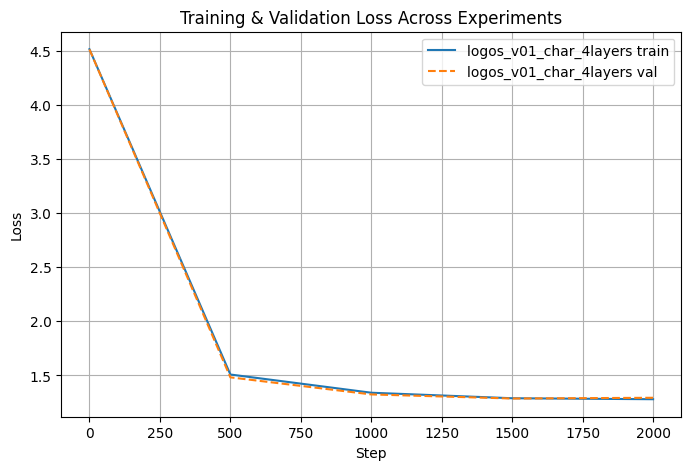

In [14]:
# --- PLOTTING LOSS OVER TIME (USING IN-MEMORY DATAFRAME) ---

plt.figure(figsize=(8,5))
# Plotting logic remains the same, but now uses the in-memory 'df'
for run_id, g in df.groupby("run_id"):
    plt.plot(g["step"], g["train_loss"], label=f"{run_id} train")
    plt.plot(g["step"], g["val_loss"], label=f"{run_id} val", linestyle="--")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training & Validation Loss Across Experiments")
plt.show()
